<a href="https://colab.research.google.com/github/Pulsar-kkaturi/DL-Education/blob/master/VisionDL_Lecture/Lecture7_Classification_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# \[7\] Classification

In [ ]:
import os, matplotlib, csv, shutil, json, random
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from IPython.display import Image
import skimage
from skimage import io as skio
from skimage import transform as skit

# scikit-learn
import sklearn.metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init

# https://pytorch.org/vision/stable/datasets.html
# 파이토치에서는 torchvision.datasets에 MNIST 등의 다양한 데이터를 사용하기 용이하게 정리해놨습니다.
# 이를 사용하면 데이터를 따로 학습에 맞게 정리하거나 하지 않아도 바로 사용이 가능합니다.
import torchvision.datasets as dset

# https://pytorch.org/vision/stable/transforms.html
# torchvision.transforms에는 이미지 데이터를 자르거나 확대 및 다양하게 변형시키는 함수들이 구현되어 있습니다.
import torchvision.transforms as transforms

# https://pytorch.org/docs/stable/data.html
# DataLoader는 전처리가 끝난 데이터들을 지정한 배치 크기에 맞게 모아서 전달해주는 역할을 합니다.
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

print(torch.__version__)

## 1. VGG

### 1.1. Data Loading
* Kaggle Garbage Classification Dataset
  - Reference link: https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification

In [ ]:
# Dataset Download
!git clone https://github.com/Pulsar-kkaturi/DL-Education.git

In [ ]:
# 데이터 압축 풀기
!tar -zxf ./DL-Education/dataset/garbage_cls_2d.tar.gz

In [ ]:
data_path = './garbage_cls_2d'
label_list = list(sorted(os.listdir(data_path)))
print(label_list)

In [ ]:
# data number check
for c in label_list:
  cn = 0
  cls_path = os.path.join(data_path, c)
  for f in os.listdir(cls_path):
    cn += 1
  print(f'{c} number = {cn}')

In [ ]:
# Data visulization
plt.figure(figsize=(12,6))
for i, c in enumerate(label_list):
  cls_path = os.path.join(data_path, c)
  sam_path = os.path.join(cls_path, os.listdir(cls_path)[0])
  sam_arr = skio.imread(sam_path)
  plt.subplot(2,3,i+1)
  plt.title(c)
  plt.imshow(sam_arr)

### 1.2. Data Preprocessing

#### 1.2.1. Data Processing 

In [ ]:
# one-hot encoding
for c in label_list:
  onehot = [0]*len(label_list)
  onehot[label_list.index(c)] = 1
  print(c, label_list.index(c), onehot)

In [ ]:
# Numpy array로 데이터 변환
data_dic, label_dic = {}, {}
for key in label_list:
  data_dic[key] = []
  label_dic[key] = []

for i, c in enumerate(label_list):
  cls_path = os.path.join(data_path, c)
  for f in sorted(os.listdir(cls_path)):
    file_path = os.path.join(cls_path, f)
    data_arr = skio.imread(file_path)
    onehot = [0]*len(label_list)
    onehot[label_list.index(c)] = 1
    data_dic[c].append(data_arr)
    label_dic[c].append(onehot)

In [ ]:
plt.figure(figsize=(12,6))
for i, k in enumerate(data_dic.keys()):
  print(f'{k}: data_number = {len(data_dic[k])}, label_number = {len(label_dic[k])}')
  plt.subplot(2,3,i+1)
  plt.title(f'{k}: {label_dic[k][0]}')
  plt.imshow(data_dic[k][0])

In [ ]:
plt.figure(figsize=(12,7))
for i, k in enumerate(data_dic.keys()):
  print(f'{k}: data_number = {len(data_dic[k])}, label_number = {len(label_dic[k])}')
  plt.subplot(2,3,i+1)
  plt.title(f'{k}: {label_dic[k][0]}')
  resize_img = skit.resize(data_dic[k][0], (128, 128))
  plt.imshow(resize_img)

#### 2.2. Tensor Setting

In [ ]:
train_paths, val_paths = [], []
label_num = {}
for k in label_list:
  label_num[k] = 0
for i, c in enumerate(label_list):
  cls_path = os.path.join(data_path, c)
  for f in sorted(os.listdir(cls_path)):
    label_num[c] += 1
    file_path = os.path.join(cls_path, f)
    if label_num[c] <= 50:
      val_paths.append(file_path)
    else:
      train_paths.append(file_path)
print(len(train_paths), len(val_paths))

In [ ]:
class GarbageDataset(Dataset):
    def __init__(self, img_list, label_list, resize):
        self.img_list = img_list
        self.label_list = label_list
        self.resize = resize

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        # 데이터 로딩
        img_path = self.img_list[idx]
        img_arr = skio.imread(img_path)
        res_arr = skit.resize(img_arr, self.resize)
        fin_arr = np.moveaxis(res_arr, -1, 0)
        # one-hot label
        c = img_path.split('/')[-2]
        onehot = [0]*len(self.label_list)
        onehot[self.label_list.index(c)] = 1
        img_tensor = torch.tensor(fin_arr, dtype=torch.float32)
        lab_tensor = torch.tensor(onehot, dtype=torch.float32)
        return img_tensor, lab_tensor

In [ ]:
np.random.shuffle(train_paths)
print(train_paths)
print(val_paths)
new_size = (128, 128) #(128, 256, 256)

gar_train = GarbageDataset(train_paths, label_list, new_size)
gar_val = GarbageDataset(val_paths, label_list, new_size)

# 데이터셋 확인 (torch tensor)
print(gar_train.__getitem__(0)[0].size(), gar_train.__getitem__(0)[1].size(), gar_train.__len__())
print(gar_val.__getitem__(0)[0].size(), gar_val.__getitem__(0)[1].size(), gar_val.__len__())

In [ ]:
plt.figure(figsize=(8,8))
for i in range(4):
    plt.subplot(2,2,i+1)
    img = gar_train[i*2][0].numpy()
    img = np.moveaxis(img, 0, -1)
    onehot = gar_train[i*2][1].numpy()
    lab = label_list[onehot.argmax()]
    plt.imshow(img, cmap='gray')
    plt.title(f'{lab}: {onehot}')

### 2.3 Model Build

In [47]:
# Block
def conv_2_block(in_dim,out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim,kernel_size=3,padding=1),
        nn.BatchNorm2d(out_dim),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.BatchNorm2d(out_dim),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )
    return model

def conv_3_block(in_dim,out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim,kernel_size=3,padding=1),
        nn.BatchNorm2d(out_dim),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.BatchNorm2d(out_dim),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.BatchNorm2d(out_dim),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )
    return model

In [48]:
class VGG16(nn.Module):
    def __init__(self, base_dim, size, num_classes=2):
        super(VGG16, self).__init__()
        self.size = int(size/32)
        self.feature = nn.Sequential(
            conv_2_block(3,base_dim),
            conv_2_block(base_dim,2*base_dim),
            conv_3_block(2*base_dim,4*base_dim),
            conv_3_block(4*base_dim,8*base_dim),
            conv_3_block(8*base_dim,8*base_dim),            
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(8*base_dim * self.size**2, 1000),
            nn.BatchNorm1d(1000),
            nn.ReLU(True),                                                      # True 는 inplace 연산을 하겠다는 의미를 가집니다. inplace 연산은 결과값을 새로운 변수에 값을 저장하는 대신 기존의 데이터를 대체하는것을 의미합니다.
            nn.Dropout(0.5),
            nn.Linear(1000, 500),
            nn.BatchNorm1d(500),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(500, num_classes),
            nn.Softmax()
        )

    def forward(self, x):
        x = self.feature(x)
        x = x.view(x.size(0), -1)                                               # x.size(0)를 batch size로 바꿔도 같은 값입니다.
        x = self.fc_layer(x)
        return x

In [71]:
batch_size = 32
base_dim = 32
num_classes = 6

train_loader = DataLoader(gar_train, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
val_loader = DataLoader(gar_val, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=False)

In [72]:
# gpu가 사용 가능한 경우에는 device를 gpu로 설정하고 불가능하면 cpu로 설정합니다.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# 모델을 지정한 장치로 올립니다.
model = VGG16(32, 128, num_classes=num_classes).to(device)

# 손실함수
loss_func = nn.CrossEntropyLoss()

# 최적화함수로는 Adam을 사용합니다.
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

cuda:0


In [73]:
print(model)

VGG16(
  (feature): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )

### 2.4. Training

In [52]:
# 학습 모듈
def train(dataloader, model, loss_fn, optimizer, epoch):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    pbar = tqdm(total=num_batches)
    train_loss, train_correct = 0, 0

    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        # Compute prediction error
        pred = model(x)
        loss = loss_fn(pred, y)
        correct = (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Epoch result
        train_loss += loss.item()
        train_correct += correct

        # Traing Process check
        loss, acc, current = loss.item(), correct/len(x), (batch + 1) * len(x)
        pbar.set_description(f" - Batch Training[{epoch}]({current}/{size}): loss = {loss:>5f}, accuracy = {acc:>0.2f}")
        pbar.update(1)
    pbar.close()
    # epoch
    train_loss /= num_batches
    train_correct /= size
    return train_loss, 100*train_correct

In [53]:
def test(dataloader, model, loss_fn, show=False):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    if show:
        print(f"Validation Error: Accuracy: {(100*correct):>0.2f}%, Avg loss: {test_loss:>5f} \n")
    return test_loss, 100*correct

In [54]:
num_epoch = 10

best_model = None
best_loss = float('inf')
stop_patience = 0

history = {'loss': [], 'val_loss': [], 
           'accuracy': [], 'val_accuracy': []}
for t in range(num_epoch):
    stop_patience += 1
    train_loss, train_acc = train(train_loader, model, loss_func, optimizer, t+1)
    val_loss, val_acc = test(val_loader, model, loss_func, t+1)

    # Best Validation loss save
    if val_loss < best_loss:
        best_loss = val_loss
        best_model = model.state_dict()
        stop_patience = 0

    # 스케줄러 단계 실행
    scheduler.step(val_loss)
    current_lr = scheduler._last_lr[0]

    history['loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['accuracy'].append(train_acc)
    history['val_accuracy'].append(val_acc)
    print(f'# Training[{t+1}/{num_epoch}]: loss = {train_loss:>5f}, acc = {train_acc:>0.2f}, val_loss = {val_loss:5>f}, val_acc = {val_acc:>0.2f}')

    # Early Stopping
    if stop_patience > 10:
        break

out_path = os.path.join('./outputs')
os.makedirs(out_path, exist_ok=True)
torch.save(best_model, os.path.join(out_path, 'best_model.h5'))
df_hist = pd.DataFrame(history)
df_hist.to_csv(os.path.join(out_path, 'history.csv'))

 - Batch Training[1](2208/2227): loss = 1.655663, accuracy = 0.41: 100%|██████████| 69/69 [00:19<00:00,  3.57it/s]


Validation Error: Accuracy: 23.33%, Avg loss: 1.799012 

# Training[1/10]: loss = 1.663669, acc = 35.38, val_loss = 1.799012, val_acc = 23.33


 - Batch Training[2](2208/2227): loss = 1.513896, accuracy = 0.56: 100%|██████████| 69/69 [00:19<00:00,  3.60it/s]


Validation Error: Accuracy: 24.33%, Avg loss: 1.788630 

# Training[2/10]: loss = 1.566386, acc = 46.83, val_loss = 1.788630, val_acc = 24.33


 - Batch Training[3](2208/2227): loss = 1.490325, accuracy = 0.50: 100%|██████████| 69/69 [00:19<00:00,  3.59it/s]


Validation Error: Accuracy: 37.67%, Avg loss: 1.640631 

# Training[3/10]: loss = 1.545175, acc = 48.23, val_loss = 1.640631, val_acc = 37.67


 - Batch Training[4](2208/2227): loss = 1.670606, accuracy = 0.38: 100%|██████████| 69/69 [00:19<00:00,  3.59it/s]


Validation Error: Accuracy: 41.00%, Avg loss: 1.618259 

# Training[4/10]: loss = 1.507714, acc = 52.58, val_loss = 1.618259, val_acc = 41.00


 - Batch Training[5](2208/2227): loss = 1.300689, accuracy = 0.78: 100%|██████████| 69/69 [00:19<00:00,  3.60it/s]


Validation Error: Accuracy: 33.00%, Avg loss: 1.687782 

# Training[5/10]: loss = 1.486453, acc = 55.19, val_loss = 1.687782, val_acc = 33.00


 - Batch Training[6](2208/2227): loss = 1.606748, accuracy = 0.44: 100%|██████████| 69/69 [00:19<00:00,  3.60it/s]


Validation Error: Accuracy: 27.33%, Avg loss: 1.750355 

# Training[6/10]: loss = 1.495264, acc = 53.66, val_loss = 1.750355, val_acc = 27.33


 - Batch Training[7](2208/2227): loss = 1.511797, accuracy = 0.53: 100%|██████████| 69/69 [00:19<00:00,  3.55it/s]


Validation Error: Accuracy: 39.33%, Avg loss: 1.630311 

# Training[7/10]: loss = 1.470518, acc = 56.58, val_loss = 1.630311, val_acc = 39.33


 - Batch Training[8](2208/2227): loss = 1.509004, accuracy = 0.53: 100%|██████████| 69/69 [00:19<00:00,  3.59it/s]


Validation Error: Accuracy: 27.33%, Avg loss: 1.752657 

# Training[8/10]: loss = 1.486667, acc = 54.11, val_loss = 1.752657, val_acc = 27.33


 - Batch Training[9](2208/2227): loss = 1.443010, accuracy = 0.59: 100%|██████████| 69/69 [00:19<00:00,  3.59it/s]


Validation Error: Accuracy: 37.67%, Avg loss: 1.647775 

# Training[9/10]: loss = 1.500897, acc = 52.90, val_loss = 1.647775, val_acc = 37.67


 - Batch Training[10](2208/2227): loss = 1.459840, accuracy = 0.59: 100%|██████████| 69/69 [00:19<00:00,  3.59it/s]


Validation Error: Accuracy: 35.67%, Avg loss: 1.666638 

# Training[10/10]: loss = 1.451830, acc = 58.19, val_loss = 1.666638, val_acc = 35.67


### 2.5. 결과 분석

In [55]:
for key in history.keys():
    print(key, history[key])

loss [1.663668736167576, 1.5663859239522961, 1.545175111812094, 1.5077138430830361, 1.4864530649738035, 1.495263529860455, 1.4705183816992717, 1.486666554990022, 1.5008967924809111, 1.4518297323282214]
val_loss [1.799011574851142, 1.788630273607042, 1.64063118563758, 1.6182587809032865, 1.687781982951694, 1.7503552966647677, 1.6303106016582913, 1.752656923400031, 1.6477749347686768, 1.6666379902097914]
accuracy [35.38392456219129, 46.834306241580606, 48.22631342613381, 52.58194881005838, 55.18634934889987, 53.65963179164795, 56.578356533453075, 54.108666367310285, 52.896273013022, 58.19488100583745]
val_accuracy [23.333333333333332, 24.333333333333336, 37.666666666666664, 41.0, 33.0, 27.333333333333332, 39.33333333333333, 27.333333333333332, 37.666666666666664, 35.66666666666667]


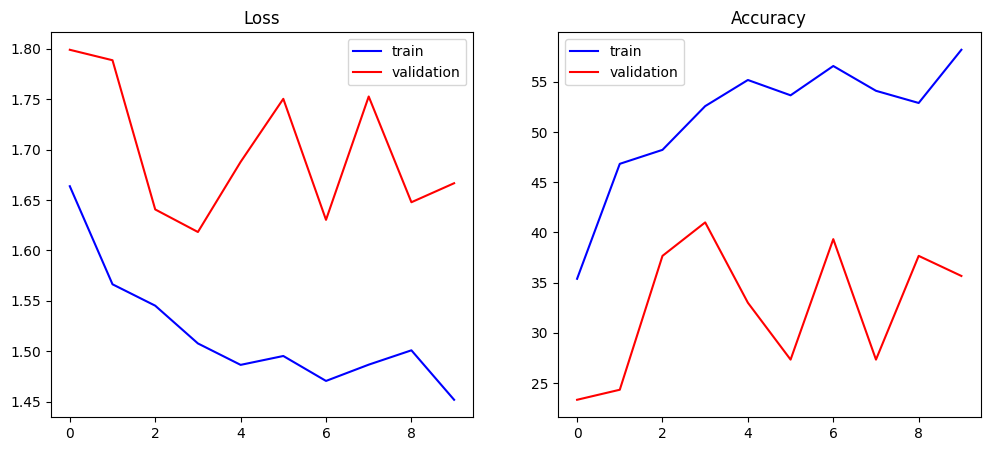

In [56]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title('Loss')
plt.plot(history['loss'], c='b', label='train')
plt.plot(history['val_loss'], c='r', label='validation')
plt.legend()
plt.subplot(122)
plt.title('Accuracy')
plt.plot(history['accuracy'], c='b', label='train')
plt.plot(history['val_accuracy'], c='r', label='validation')
plt.legend()

In [74]:
pred_dic = {'prob': [], 'pred': []}
with torch.no_grad():
    for img, lab in val_loader:
        x = img.to(device)
        pred = model.forward(x)
        for i in range(len(x)):
            probs = pred[i].cpu().detach().numpy()
            # probs -= np.min(probs)
            # probs /= np.sum(probs)
            pred_dic['prob'].append(probs)
            pred_dic['pred'].append(label_list[pred[i].argmax().item()])
print(pred_dic['pred'][0])
print(pred_dic['prob'][0])
print(len(pred_dic['pred']))

/home/student/.local/lib/python3.10/site-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


plastic
[0.08189627 0.09053405 0.19895731 0.15104261 0.35518843 0.12238133]
300


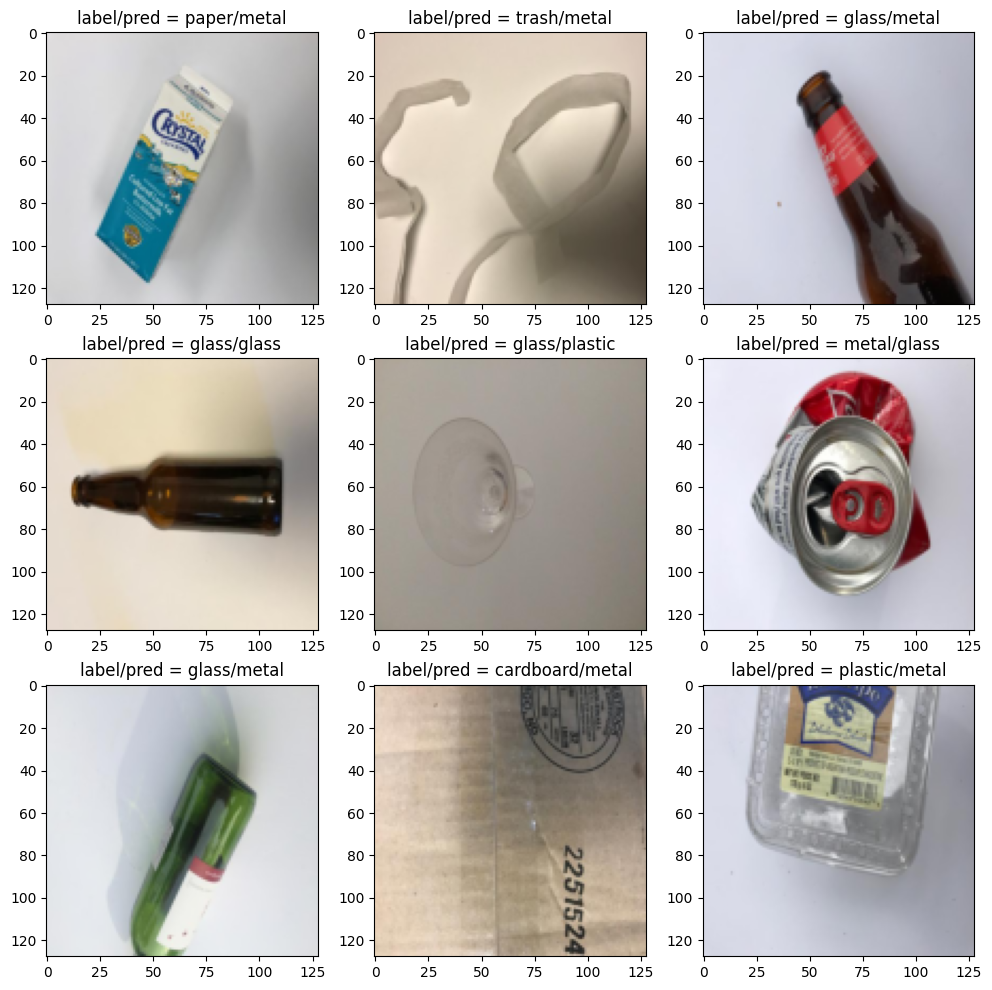

In [75]:
plt.figure(figsize=(12,12))
for i, i_ in enumerate(list(np.random.choice(np.arange(len(val_paths)), 9))):
    img = np.moveaxis(gar_val[i_][0].detach().numpy(), 0 , -1)
    pred = pred_dic['pred'][i_]
    # score = pred_dic['prob'][i][pred]
    plt.subplot(3,3,i+1)
    plt.imshow(img)
    plt.title(f'label/pred = {label_list[gar_val[i_][1].argmax()]}/{pred}')

In [85]:
true_list, false_list = [], []
for i in range(len(pred_dic['pred'])):
    pred = pred_dic['pred'][i]
    lab = label_list[gar_val[i_][1].argmax()]
    if pred == lab:
        true_list.append(i)
    else:
        false_list.append(i)
print('True Num = ', len(true_list))
print('False Num = ', len(false_list))

True Num =  24
False Num =  276
